In [2]:
from datetime import datetime

import torch
import numpy as np


import util, tr_util
from Dimploma import old_gcn
from my_gcn import GCN
from Dimploma.EnvironmentTree import EnvMinimalTreeTwoStep
from Dimploma.ppo_parallel_custom import Agent, test_random
from Dimploma.utils.graph_provider import GraphProvider

In [3]:
%load_ext autoreload
%autoreload 2

device:  cuda
Loading graph


C:\Users\Milos\AppData\Local\Temp\ipykernel_13580\1034516490.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph = torch.load(load_graph)


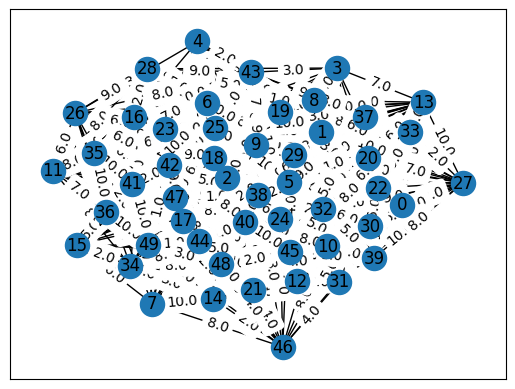

Name: n50_e612_bigger_graph_cuda
tensor([[ 0, 36,  0,  ..., 49, 28, 10],
        [36, 30,  8,  ..., 29,  8, 15]]) tensor([[ 0.2000,  0.0000,  2.0000],
        [ 1.0000,  0.0000, 10.0000],
        [ 0.3000,  0.0000,  3.0000],
        ...,
        [ 0.9000,  0.0000,  9.0000],
        [ 0.5000,  0.0000,  5.0000],
        [ 0.4000,  0.0000,  4.0000]]) tensor([[ 0.,  0.],
        [ 1.,  0.],
        [ 2.,  0.],
        [ 3.,  0.],
        [ 4.,  0.],
        [ 5.,  0.],
        [ 6.,  0.],
        [ 7.,  0.],
        [ 8.,  0.],
        [ 9.,  0.],
        [10.,  0.],
        [11.,  0.],
        [12.,  0.],
        [13.,  0.],
        [14.,  0.],
        [15.,  0.],
        [16.,  0.],
        [17.,  0.],
        [18.,  0.],
        [19.,  0.],
        [20.,  0.],
        [21.,  0.],
        [22.,  0.],
        [23.,  0.],
        [24.,  0.],
        [25.,  0.],
        [26.,  0.],
        [27.,  0.],
        [28.,  0.],
        [29.,  0.],
        [30.,  0.],
        [31.,  0.],
        [3

In [7]:
node_amount = 50
max_edge_amount = torch.sum(torch.arange(node_amount)).item()
edge_amount = int(max_edge_amount*0.5)
iteration_amount = 1000
epoch_amount = 10
batch_size = 64
node_features = 2  # (index, {0,1} selected or not)
steps_amount = int((node_amount - 1)*2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device: ', device)
early_stop = True

cat_in_net = True
conv_layers = 3
conv_p_layers = 1
linear_layers = 2


gamma=0.99
epsilon=0.1
coef_value=0.5
coef_entropy=0.001
gae_lambda=0.95
lr=0.00025


fixed_graph = True
# load_graph = 'results/min_tree_ppo/node/241217_15#n10_e45_cat_part2/graph.pt'
# load_graph = 'graphs/graph2_norm.pt'
load_graph = 'graphs/graph5_n50_norm.pt'
# load_graph = ''
save_new = False
# save_new = True
# load_from = 'results/min_tree_ppo/node/241217_15#n10_e45_cat_part2/models/iter_499_last.pt'
# load_from = 'results/min_tree_ppo/node/250103_18#n10_e45_not_fixed/models/iter_999_last.pt'
load_from = ''
graph = None

if load_graph != '':
    print('Loading graph')
    graph = torch.load(load_graph)
    util.show_data(graph)
elif fixed_graph:
    print('Fixing graph')
    graph = util.generate_random_graph_add_method(node_amount, edge_amount, device=device)
    if save_new:
        torch.save(graph, f'graphs/graph5_n{node_amount}_e{edge_amount}_norm.pt')
    util.show_data(graph)

graph_provider = GraphProvider(fixed_graph=graph, device=device, nodes=node_amount, edges=edge_amount)


name = f'n{node_amount}_e{edge_amount}_bigger_graph_cuda'

training_desc = f'''
a bigger graph with 0.5 edges
trying out training with:
fixed graph
{conv_layers}-{conv_p_layers}GAT layers
{'with' if cat_in_net else 'without'} catenation between layers
{iteration_amount} iterations
{'with' if early_stop else 'without'} early stopping

Parameters:
Gamma: {gamma}
Epsilon: {epsilon}
Coef_value: {coef_value}
Coef_Entropy: {coef_entropy}
Gae_lambda: {gae_lambda}
Learning rate: {lr}
'''

path = 'results/min_tree_ppo/node/'
last_path = f'models/iter_{iteration_amount - 1}_last.pt'
print("Name:", name)
if fixed_graph:
    print(graph.edge_index, graph.edge_attr, graph.x)

In [8]:
last_name = "fuckup"

In [9]:
start_date = datetime.now()

try:
    # noinspection PyUnresolvedReferences
    if last_name == name:
        raise Exception("You should change the name :D")
except NameError:
    raise Exception("You should init last name :D")

if training_desc == '':
    raise Exception("You should write a nice description :D")

last_name = name

net = GCN(node_amount, node_features, cat_in_net, conv_layers, conv_p_layers, linear_layers)

print(f'Agent {name}')

agent = Agent(model=net, gamma=gamma, epsilon=epsilon, coef_value=coef_value, coef_entropy=coef_entropy, gae_lambda=gae_lambda, lr=lr, device=device, path=path, name=name, override=True, early_stop=early_stop)
# agent = Agent(model=net, device=device, path=path, name=name, override=True)

if load_from != '':
    agent.load_model(load_from)

agent.training_description(training_desc)
training_desc = ''
# agent.train([device, None, node_amount, edge_amount], EnvMinimalTreeTwoStep, node_amount, count_of_processes=1, count_of_envs=1, batch_size=32, count_of_iterations=iteration_amount)
agent.train([graph_provider], EnvMinimalTreeTwoStep, node_amount, count_of_iterations=iteration_amount, count_of_epochs=epoch_amount, batch_size=batch_size, count_of_steps=steps_amount)


end_date = datetime.now()
torch.save(graph, agent.path + '/graph.pt')
s = (end_date - start_date).seconds
hours, remainder = divmod(s, 3600)
minutes, seconds = divmod(remainder, 60)
#-1.42077
print(f'Time training {int(hours):02}:{int(minutes):02}:{int(seconds):02}')

Agent n50_e612_bigger_graph_cuda
Training is starting
Iteration 0 starting
Iteration 0	episode 32	avg score -2.87500	best score -2.01887	best avg score -2.87500
Writing to early val: -2.875
Iteration 1 starting
Iteration 1	episode 64	avg score -2.91922	best score -2.01887	best avg score -2.87500
Iteration 2 starting
Iteration 2	episode 96	avg score -2.92355	best score -2.01887	best avg score -2.87500
Iteration 3 starting
Iteration 3	episode 128	avg score -2.93434	best score -2.01887	best avg score -2.87500
Iteration 4 starting
Iteration 4	episode 160	avg score -2.93434	best score -2.01887	best avg score -2.87500
Iteration 5 starting
Iteration 5	episode 192	avg score -2.93057	best score -2.01887	best avg score -2.87500
Iteration 6 starting
Iteration 6	episode 224	avg score -2.91755	best score -2.01887	best avg score -2.87500
Iteration 7 starting
Iteration 7	episode 256	avg score -2.84811	best score -2.01887	best avg score -2.84811
Iteration 8 starting
Iteration 8	episode 288	avg score -

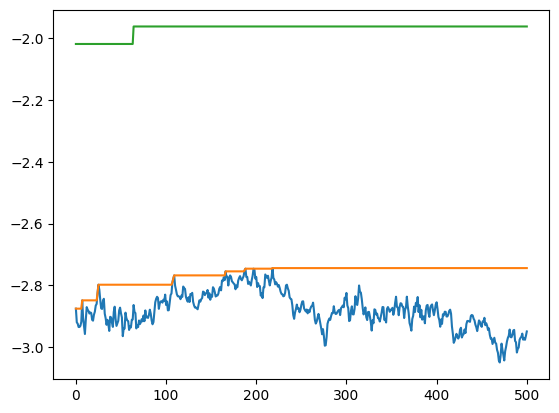

C:\Users\Milos\PycharmProjects\MyDiploma\Dimploma\tr_util.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_graph = torch.load(testesing_agent + '/graph.pt')


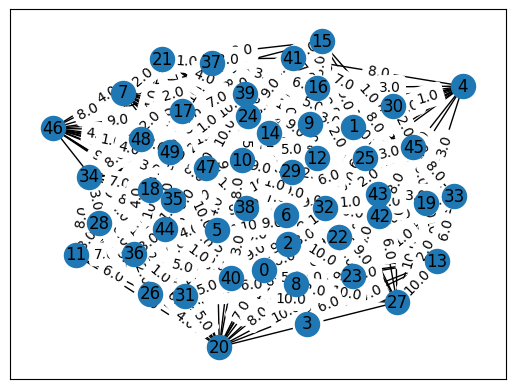

Loading model from results/min_tree_ppo/node/250219_15#n50_e612_bigger_graph_cuda//models/iter_999_last.pt


C:\Users\Milos\PycharmProjects\MyDiploma\Dimploma\ppo_parallel_custom.py:376: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(path))


In [10]:
loaded_graph, test_env, agent_test = tr_util.load_agent_for_testing(agent.path, iteration_amount, graph_provider, GCN(node_amount, node_features, cat_in_net, conv_layers, conv_p_layers, linear_layers), device)

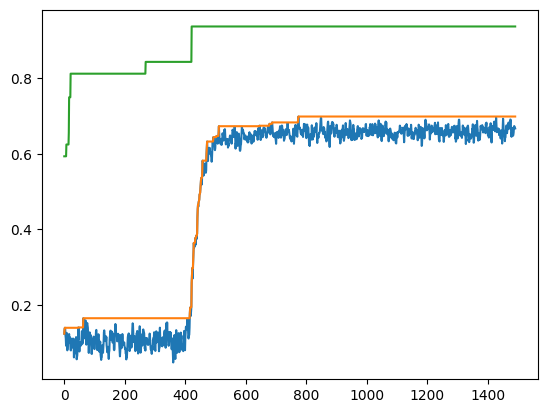

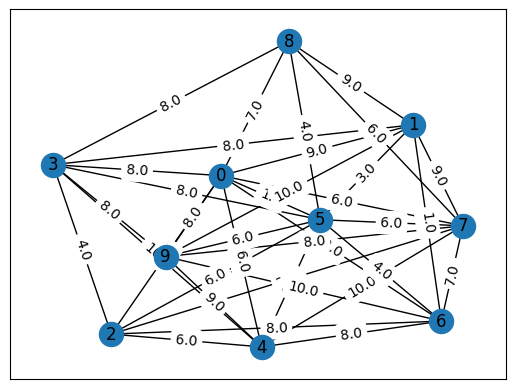

Loading model from results/min_tree_ppo/node/250204_20#n10_e36_eps03/models/iter_1499_last.pt


In [21]:
# loaded_graph, test_env, agent_test = tr_util.load_agent_for_testing('results/min_tree_ppo/node/250204_20#n10_e36_eps03', 1500, graph_provider, old_gcn.GCN31(node_amount, node_features), device)

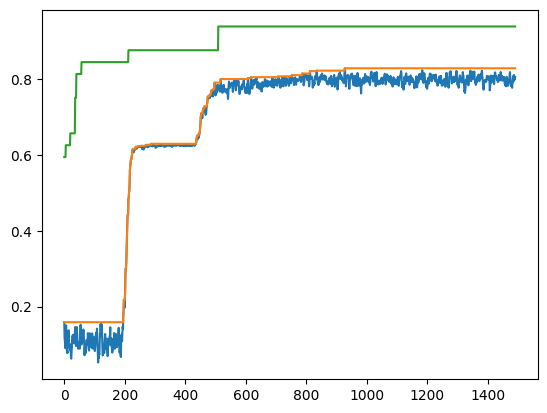

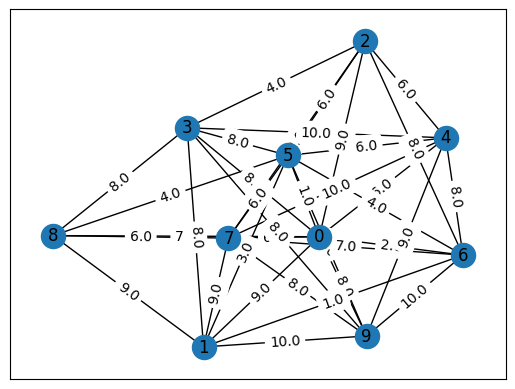

Loading model from results/min_tree_ppo/node/250205_13#n10_e36_eps02/models/iter_1499_last.pt


In [24]:
# loaded_graph, test_env, agent_test = tr_util.load_agent_for_testing('results/min_tree_ppo/node/250205_13#n10_e36_eps02', 1500, graph_provider, old_gcn.GCN31(node_amount, node_features), device)

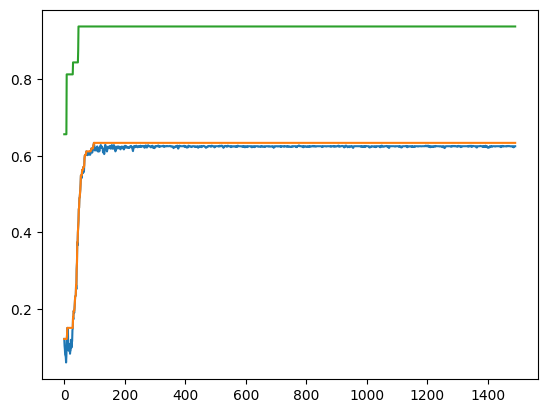

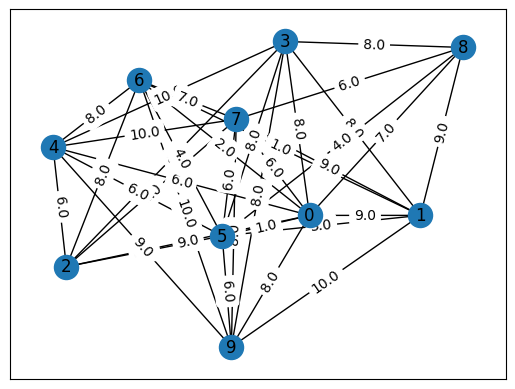

Loading model from results/min_tree_ppo/node/250205_16#n10_e36_gat2-1_at2/models/iter_1499_last.pt


In [25]:
# loaded_graph, test_env, agent_test = tr_util.load_agent_for_testing('results/min_tree_ppo/node/250205_16#n10_e36_gat2-1_at2', 1500, graph_provider, old_gcn.GCN21(node_amount, node_features), device)

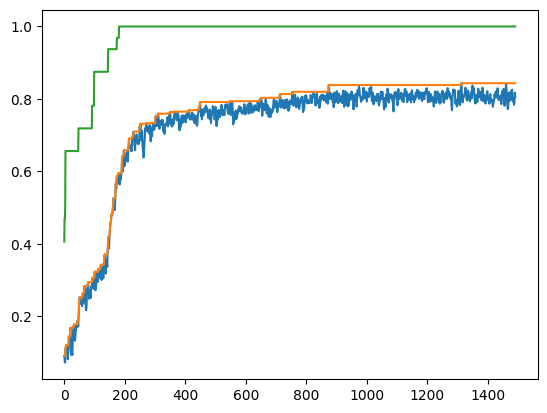

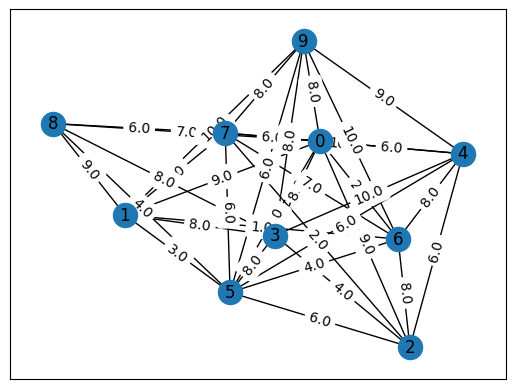

Loading model from results/min_tree_ppo/node/250205_19#n10_e36_gat3-2_at2/models/iter_1499_last.pt


In [55]:
# loaded_graph, test_env, agent_test = tr_util.load_agent_for_testing('results/min_tree_ppo/node/250205_19#n10_e36_gat3-2_at2', 1500, graph_provider, old_gcn.GCN32(node_amount, node_features), device)

In [11]:
# Testing
test_amount = 100
objs_test = np.zeros(test_amount, dtype=np.float32)
rews_test = np.zeros(test_amount, dtype=np.float32)
actions_test = np.zeros((test_amount, node_amount * 2), dtype=np.int16)

objs_test_r = np.zeros(test_amount, dtype=np.float32)
rews_test_r = np.zeros(test_amount, dtype=np.float32)
actions_test_r = np.zeros((test_amount, node_amount * 2), dtype=np.int16)

for i in range(test_amount):
    obj, sel, rew, acts = agent_test.test(test_env)
    objs_test[i] = obj
    rews_test[i] = rew[-1]
    actions_test[i, :len(acts)] = acts
    
    obj_r, sel_r, rew_r, acts_r  = test_random(test_env)
    objs_test_r[i] = obj_r
    rews_test_r[i] = rew_r[-1]
    actions_test_r[i, :len(acts_r)] = acts_r
    # print(sel)

print("Objs")
print(f'Mean: {objs_test.mean():.2f}')
print(f'Min: {objs_test.min()}')
print(f'Max: {objs_test.max()}')
print("Random")
print(f'Mean: {objs_test_r.mean():.2f}')
print(f'Min: {objs_test_r.min()}')
print(f'Max: {objs_test_r.max()}')

Objs
Mean: 264.74
Min: 229.0
Max: 293.0
Random
Mean: 279.05
Min: 232.0
Max: 321.0


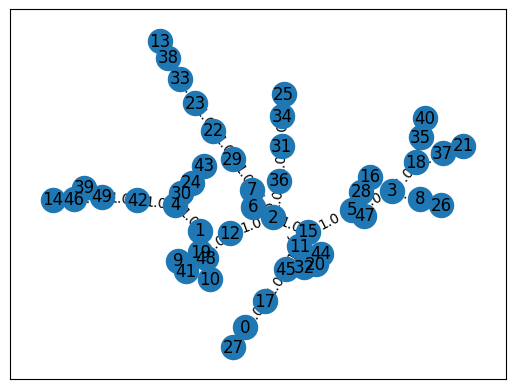

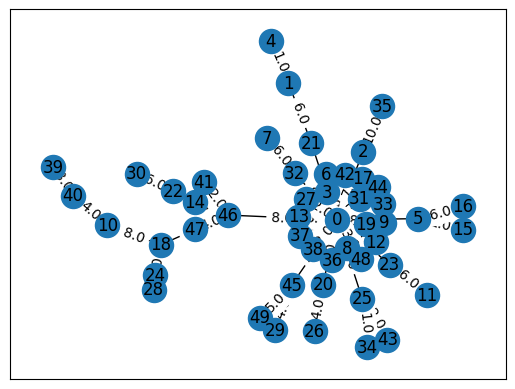

(tensor([1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 1., 0.,

In [12]:
_ ,a, b, c = agent_test.test(test_env)
util.show_data(test_env.min_tree)
test_env.show_selected_tree()

# mask = torch.argwhere(graph_test.edge_attr[:, 1] == 1)[:, 0]
# sel_graph = Data(x=graph_test.x, edge_index=graph_test.edge_index[:, mask], edge_weight=graph_test.edge_weight[mask])
# sel_graph_g = util.my_to_networkx(sel_graph)
# util.show_data(sel_graph)
a,b,c

In [13]:
util.get_node_sums(loaded_graph)

tensor([[ 4.0000, 46.0000, 34.0000, 20.0000,  3.0000,  7.0000, 15.0000, 11.0000,
         28.0000, 37.0000, 26.0000, 13.0000, 33.0000, 41.0000, 21.0000, 45.0000,
         39.0000, 30.0000, 22.0000, 36.0000, 27.0000,  5.0000, 35.0000,  8.0000,
         40.0000,  0.0000,  2.0000, 43.0000, 19.0000, 29.0000,  1.0000, 38.0000,
         31.0000, 14.0000, 16.0000, 23.0000, 32.0000, 25.0000, 12.0000, 44.0000,
         48.0000, 42.0000, 49.0000, 10.0000, 24.0000,  6.0000, 18.0000, 17.0000,
          9.0000, 47.0000],
        [ 6.5000,  8.8000,  9.4000,  9.8000,  9.9000, 10.5000, 10.5000, 10.8000,
         11.1000, 11.2000, 11.2000, 12.0000, 12.3000, 12.4000, 12.7000, 12.7000,
         13.1000, 13.2000, 13.2000, 13.4000, 13.5000, 13.7000, 13.9000, 14.1000,
         14.4000, 14.4000, 14.5000, 14.5000, 14.6000, 14.7000, 15.0000, 15.1000,
         15.1000, 15.2000, 15.6000, 15.6000, 16.0000, 16.2000, 16.4000, 16.8000,
         17.0000, 17.1000, 17.1000, 17.4000, 17.9000, 17.9000, 18.0000, 18.2000,


In [14]:
util.get_out_edges(loaded_graph)

tensor([[ 4., 46., 37.,  3., 28., 20., 34.,  7., 15., 27., 26., 13., 33., 11.,
         35., 30., 31., 43., 21., 36., 22., 41.,  8., 23., 39., 45., 29., 14.,
         40.,  0., 42.,  5., 16.,  2., 25., 32., 12., 19.,  6., 44.,  1., 49.,
         17.,  9., 48., 38., 10., 24., 18., 47.],
        [15., 17., 18., 19., 19., 19., 20., 20., 20., 20., 21., 21., 21., 21.,
         21., 22., 22., 23., 23., 23., 24., 24., 25., 25., 25., 25., 26., 26.,
         26., 26., 26., 26., 26., 27., 27., 27., 28., 28., 28., 28., 28., 28.,
         29., 29., 29., 30., 30., 30., 30., 33.]])